<a href="https://colab.research.google.com/github/pedrogzz18/Traffic-Signs-Recognition/blob/main/TrafficSignsRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
! pip install -q kaggle

In [5]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"p3dr0gzz","key":"63a47cd3b37c9df0d410c46a42b9de32"}'}

In [11]:
!mkdir ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


In [12]:
! cp kaggle.json ~/.kaggle/

In [13]:
! chmod 600 ~/.kaggle/kaggle.json

In [14]:
!kaggle datasets download -d valentynsichkar/traffic-signs-preprocessed

100% 4.15G/4.16G [00:33<00:00, 204MB/s]
100% 4.16G/4.16G [00:33<00:00, 134MB/s]


In [15]:
! mkdir traffic_signs_preprocessed
! unzip traffic-signs-preprocessed.zip -d traffic_signs_preprocessed

Archive:  traffic-signs-preprocessed.zip
  inflating: traffic_signs_preprocessed/data0.pickle  
  inflating: traffic_signs_preprocessed/data1.pickle  
  inflating: traffic_signs_preprocessed/data2.pickle  
  inflating: traffic_signs_preprocessed/data3.pickle  
  inflating: traffic_signs_preprocessed/data4.pickle  
  inflating: traffic_signs_preprocessed/data5.pickle  
  inflating: traffic_signs_preprocessed/data6.pickle  
  inflating: traffic_signs_preprocessed/data7.pickle  
  inflating: traffic_signs_preprocessed/data8.pickle  
  inflating: traffic_signs_preprocessed/datasets_preparing.py  
  inflating: traffic_signs_preprocessed/label_names.csv  
  inflating: traffic_signs_preprocessed/labels.pickle  
  inflating: traffic_signs_preprocessed/mean_image_gray.pickle  
  inflating: traffic_signs_preprocessed/mean_image_rgb.pickle  
  inflating: traffic_signs_preprocessed/std_gray.pickle  
  inflating: traffic_signs_preprocessed/std_rgb.pickle  
  inflating: traffic_signs_preprocessed/te

In [17]:
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py

Cloning into 'rapidsai-csp-utils'...
remote: Enumerating objects: 476, done.
remote: Counting objects: 100% (207/207), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 476 (delta 141), reused 124 (delta 91), pack-reused 269
Receiving objects: 100% (476/476), 131.59 KiB | 2.39 MiB/s, done.
Resolving deltas: 100% (243/243), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.1 MB/s eta 0:00:00
***********************************************************************
Woo! Your instance has a Tesla T4 GPU!
We will install the latest stable RAPIDS via pip 24.4.*!  Please stand by, should be quick...
***********************************************************************

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.3/473.3 MB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 911.7 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 GB 51

In [1]:
%load_ext cudf.pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

## **Import Dataset**

We are gonna use the dataset from https://www.kaggle.com/datasets/valentynsichkar/traffic-signs-preprocessed. With images that are already preprocesed and using 43 labels in total. The initial dats is German Traffic Sign Recognition Benchmarks (GTSRB)

In [2]:
traffic_signs = pd.read_pickle("traffic_signs_preprocessed/data0.pickle")
traffic_signs.keys()

dict_keys(['x_test', 'y_validation', 'x_validation', 'labels', 'x_train', 'y_test', 'y_train'])

In [3]:
traffic_signs['x_train'].shape

(86989, 3, 32, 32)

In [4]:
traffic_signs['y_train'].max()

42

In this dataset there are 43 different classes already converted to categorical variables

In [5]:
labels = pd.read_csv("traffic_signs_preprocessed/label_names.csv")
labels.shape

(43, 2)

In [6]:
labels.head()

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


In [7]:
num_classes = labels.shape[0]
num_classes

43

# **Pre-processing**

Next we transpose the values since the images are given with shape (3, 32, 32) and we want them (32,32,3)

In [8]:
X_train = np.transpose(traffic_signs['x_train'], (0, 2, 3, 1))
y_train = traffic_signs['y_train']
X_val = np.transpose(traffic_signs['x_validation'], (0,2,3,1))
y_val = traffic_signs['y_validation']
X_test = np.transpose(traffic_signs['x_test'], (0, 2, 3, 1))
y_test = traffic_signs['y_test']

We can check in fact, those are the right dimensions

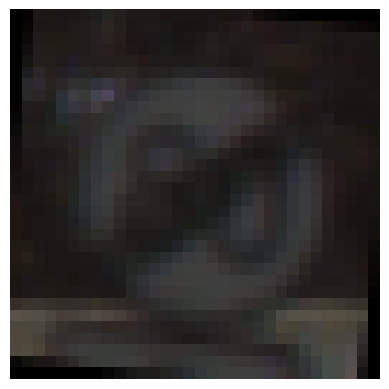

ClassId                               6
SignName    End of speed limit (80km/h)
Name: 6, dtype: object

In [35]:
plt.imshow(X_train[20])
plt.axis("off")
plt.show()
labels.iloc[y_train[20]]

Check distribution of class labels:

Text(0, 0.5, 'frequency')

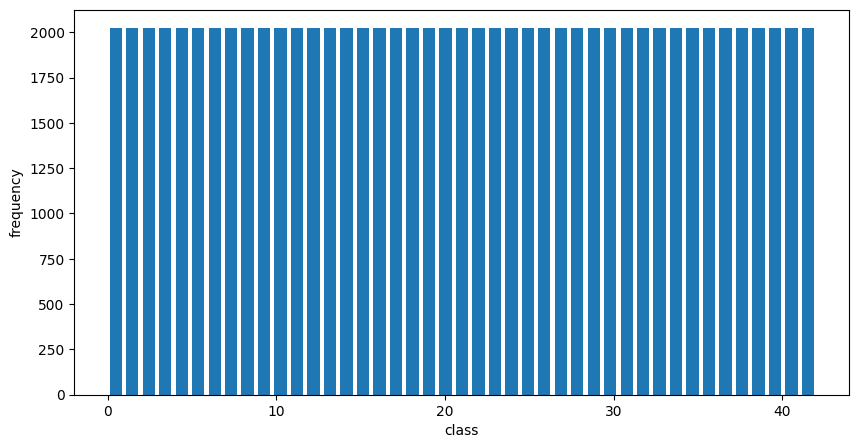

In [36]:
plt.figure(figsize=(10, 5))
plt.hist(y_train,  bins=43, rwidth=0.75)
plt.xlabel("class")
plt.ylabel("frequency")

Scale the images

In [37]:
X_train = X_train/255.0
X_val = X_val/255.0
X_test = X_test/255.0

# **Create the model**

Build our own CNN model

In [12]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten

def build_model(optimizer):
  traffic_signs_nn = Sequential([
      Conv2D(input_shape=(32,32,3), filters=64, kernel_size=(3,3), activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.2),
      Conv2D(kernel_size=(3,3), filters=64, activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Conv2D(kernel_size=(3,3), filters=64, activation='relu'),
      MaxPooling2D(pool_size=(2,2)),
      Dropout(rate=0.2),
      Flatten(),
      Dense(units=64, activation='relu'),
      Dense(units=43, activation='softmax')
  ])
  traffic_signs_nn.summary()
  traffic_signs_nn.compile(metrics=['accuracy'], optimizer=optimizer, loss='sparse_categorical_crossentropy')
  return traffic_signs_nn


In [13]:
from tensorflow.keras.callbacks import EarlyStopping

traffic_signs_clf = build_model('adam')

history = traffic_signs_clf.fit(
    X_train, y_train,
    batch_size=100,
    epochs=200,
    callbacks=[EarlyStopping(min_delta=0.001, patience=7)],
    validation_data=(X_val, y_val),
    verbose=1
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 15, 15, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          3

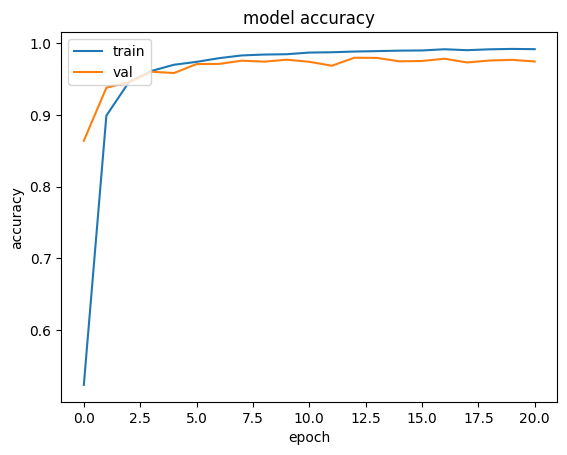

In [14]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
from sklearn.metrics import accuracy_score
y_test_prob = traffic_signs_clf.predict(X_test)
y_classes = y_test_prob.argmax(axis=-1)
print("Test accuracy : ", accuracy_score(y_classes, y_test))

395/395 [==============================] - 1s 2ms/step
Test accuracy :  0.951464766429137


In [20]:
from PIL import Image
import cv2
img = Image.open('/content/image_testing/yiekd.jpeg')
image = img.resize((32,32))
# asarray() class is used to convert
# PIL images into NumPy arrays
image = np.asarray(image)
image = image/255.0
# <class 'numpy.ndarray'>
print(type(image))

#  shape
print(image.shape)

label = traffic_signs_clf.predict(np.array([image])).argmax(axis=-1)[0]

labels.iloc[label]

<class 'numpy.ndarray'>
(32, 32, 3)
1/1 [==============================] - 0s 74ms/step


ClassId        13
SignName    Yield
Name: 13, dtype: object

# **ResNet50 model**

Now, we use the ResNet50 model from tensorflow.keras.application and check the results

In [24]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(units=128, activation='relu')(x)
predictions = Dense(43, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 16, 16, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [25]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    X_train, y_train,
    batch_size=100,
    epochs=200,
    callbacks=[EarlyStopping(min_delta=0.001, patience=7)],
    validation_data=(X_val, y_val),
    verbose=1
)

Epoch 1/200
870/870 [==============================] - 98s 69ms/step - loss: 0.4321 - accuracy: 0.8849 - val_loss: 1.3471 - val_accuracy: 0.6943
Epoch 2/200
870/870 [==============================] - 56s 64ms/step - loss: 0.0955 - accuracy: 0.9749 - val_loss: 0.5849 - val_accuracy: 0.8939
Epoch 3/200
870/870 [==============================] - 55s 64ms/step - loss: 0.0956 - accuracy: 0.9752 - val_loss: 0.2555 - val_accuracy: 0.9370
Epoch 4/200
870/870 [==============================] - 55s 64ms/step - loss: 0.0500 - accuracy: 0.9870 - val_loss: 0.1587 - val_accuracy: 0.9615
Epoch 5/200
870/870 [==============================] - 55s 64ms/step - loss: 0.0496 - accuracy: 0.9873 - val_loss: 0.2955 - val_accuracy: 0.9420
Epoch 6/200
870/870 [==============================] - 55s 63ms/step - loss: 0.0549 - accuracy: 0.9863 - val_loss: 0.2390 - val_accuracy: 0.9467
Epoch 7/200
870/870 [==============================] - 55s 64ms/step - loss: 0.0502 - accuracy: 0.9880 - val_loss: 0.2158 - val_ac

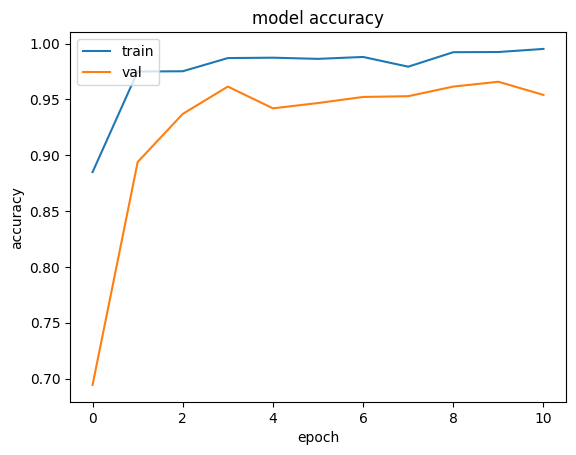

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
from sklearn.metrics import accuracy_score
y_test_prob = traffic_signs_clf.predict(X_test)
y_classes = y_test_prob.argmax(axis=-1)
print("Test accuracy : ", accuracy_score(y_classes, y_test))

395/395 [==============================] - 1s 3ms/step
Test accuracy :  0.951464766429137


In [32]:
from PIL import Image
import cv2
img = Image.open('/content/image_testing/stop1.jpeg')
image = img.resize((32,32))
# asarray() class is used to convert
# PIL images into NumPy arrays
image = np.asarray(image)
image = image/255.0
# <class 'numpy.ndarray'>
print(type(image))

#  shape
print(image.shape)

label = traffic_signs_clf.predict(np.array([image])).argmax(axis=-1)[0]

labels.iloc[label]

<class 'numpy.ndarray'>
(32, 32, 3)
1/1 [==============================] - 0s 33ms/step


ClassId       14
SignName    Stop
Name: 14, dtype: object

The dataset has not much detail in their images but we still achieve good results with just a simple CNN